In [2]:
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from scipy import stats
import scipy
import csv
import pandas as pd
import math
import statsmodels
import networkx as nx
import itertools
import seaborn as sns
import random
import os
from textwrap import wrap
import pickle
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.multiclass import OneVsRestClassifier
from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [3]:
def load_spots(chromosome):
    with open("data/spots/"+chromosome+"_hotspot_data.pickle", "rb") as fp:
         hotspot_data = pickle.load(fp)
    with open("data/spots/"+chromosome+"_coldspot_data.pickle", "rb") as fp:
         coldspot_data = pickle.load(fp)
    return hotspot_data, coldspot_data

def create_dataset(hotspots, coldspots, only_seq=False):
    X, y = [], []
    for row in hotspots:
        if only_seq: row = row[:, :4]
        X.append(row.flatten())
        y.append(1)
    
    for row in coldspots:
        if only_seq: row = row[:, :4]
        X.append(row.flatten())
        y.append(0)
    
    return np.array(X), np.array(y)

def get_data(chromosomes):
    hotspots, coldspots = [], []
    for chromosome in chromosomes:
        hotspot, coldspot = load_spots(chromosome)
        hotspots+=hotspot
        coldspots+=coldspot
    return hotspots, coldspots

In [4]:
train_chromosomes = ['chr{}'.format(i) for i in range(1, 10, 2)]
train_hotspot, train_coldspot = get_data(train_chromosomes)

test_chromosomes = ['chr{}'.format(i) for i in range(11, 12)]
test_hotspot, test_coldspot = get_data(test_chromosomes)

In [5]:
def try_classifier(model, only_seq):
    x_train, y_train = create_dataset(train_hotspot, train_coldspot, only_seq=only_seq) 
    x_test, y_test = create_dataset(test_hotspot, test_coldspot, only_seq=only_seq) 
    
    results = cross_validate(model, x_train, y_train, cv=5, return_estimator=False)
    cv_scores = np.mean(results['test_score'])
    print('cv: {}'.format(cv_scores))

    model.fit(x_train, y_train)
    test_score = model.score(x_test, y_test)
    print('test_score: {}'.format(test_score))
    prob = model.predict_proba(x_test)
    return prob

In [20]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(class_weight='balanced')
LR_seq = try_classifier(model, only_seq=True)
LR_exo = try_classifier(model, only_seq=False)

cv: 0.6126726040526561
test_score: 0.655310621242485
cv: 0.6420745610580555
test_score: 0.6489902882688454


In [21]:
from sklearn.naive_bayes impo rt GaussianNB
model = GaussianNB()
NB_seq = try_classifier(model, only_seq=True)
NB_exo = try_classifier(model, only_seq=False)

cv: 0.6637625414257913
test_score: 0.7058732850316016
cv: 0.5769581231840546
test_score: 0.5316787420995838


In [22]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_jobs=-1, class_weight='balanced', bootstrap=False)
DT_seq = try_classifier(model, only_seq=True)
DT_exo = try_classifier(model, only_seq=False)

cv: 0.5978639525993815
test_score: 0.6081393556343456
cv: 0.6202523701309746
test_score: 0.6190843224911361


In [87]:
models = ['Logistic Regression', 'Naïve Bayes', 'Random Forest Classifier', 'Simple NN', 'Hybrid CRNN']

cv_seq = [0.6126726040526561, 0.6637625414257913, 0.5966229696837516, .626, .751]
test_score_seq = [0.655310621242485, 0.7058732850316016, 0.6086018190226608, .67, .735]

cv_exo = [0.6420745610580555, 0.5769581231840546, 0.6202523701309746, .67, .7835]
test_score_exo = [0.6489902882688454, 0.5316787420995838, 0.6195467858794512, .66, .7226]

cv_exo, cv_seq, models =  zip(*sorted(zip(cv_exo, cv_seq, models)))

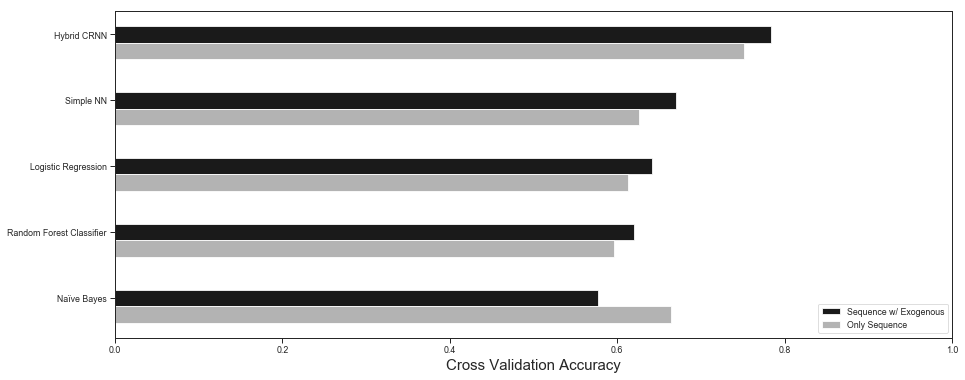

In [88]:
sns.set_style("ticks")
sns.set_context("paper", rc={"font.size":15,"axes.titlesize":15,"axes.labelsize":15}) 

# set width of bar
barWidth = 0.25
 
# set height of bar
bars1 = cv_seq
bars2 = cv_exo
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
 
# Make the plot
plt.figure(figsize=(15,6))
plt.barh(r2, bars2, color='.1', height=barWidth, edgecolor='white', label='Sequence w/ Exogenous')
plt.barh(r1, bars1, color='.7', height=barWidth, edgecolor='white', label='Only Sequence')
 
# Add xticks on the middle of the group bars
plt.yticks([r + barWidth for r in range(len(bars1))], models)
plt.xlabel('Cross Validation Accuracy')
plt.xlim(0,1) 
# Create legend & Show graphic
plt.legend(loc='lower right')
plt.savefig("img/CV_v2.png", bbox_inches='tight')

In [29]:
x_train, y_train = create_dataset(train_hotspot, train_coldspot, only_seq=False) 
x_test, y_test = create_dataset(test_hotspot, test_coldspot, only_seq=False)

No Skill: ROC AUC=0.500
Logistic Regression: ROC AUC=0.709
Naïve Bayes: ROC AUC=0.600
Random Forest Classifier: ROC AUC=0.621
Simple NN: ROC AUC=0.715
Hybrid CRNN: ROC AUC=0.802


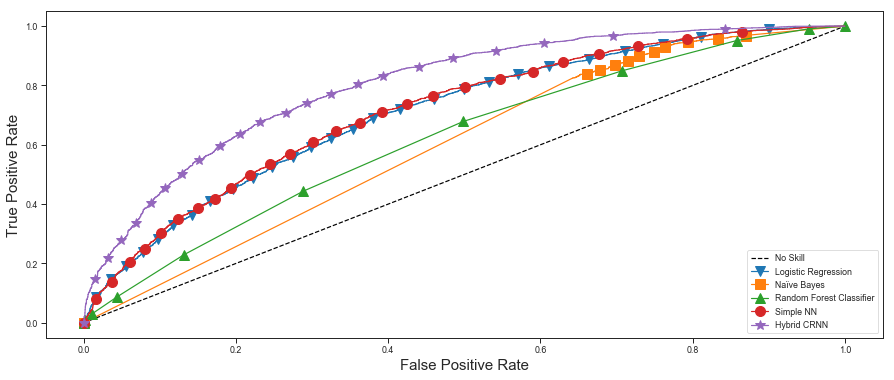

In [100]:
ns_probs = np.array([[1, 0] for i in range(len(LR_exo))])
models_prob = [ns_probs, LR_exo, NB_exo, DT_exo, SNN_exo, CRNN_exo]
models =  ['No Skill', 'Logistic Regression',  'Naïve Bayes', 'Random Forest Classifier', 'Simple NN', 'Hybrid CRNN']

# calculate scores
auc_score = [roc_auc_score(y_test , model[:,1]) for model in models_prob]

# summarize scores
for i in range(len(models)):
    print('{}: ROC AUC=%.3f'.format(models[i]) % (auc_score[i]))

# calculate roc curves
fprs = [roc_curve(y_test , model[:,1])[0] for model in models_prob]
tprs = [roc_curve(y_test , model[:,1])[1] for model in models_prob]
markers = ['',"v", "^", "8", "s", "p", "P", "*", '.']

plt.figure(figsize=(15,6))
# plot the roc curve for the model
plt.plot(fprs[0], tprs[0], marker='', label='No Skill', markersize=10, linestyle='dashed', c='0')
plt.plot(fprs[1], tprs[1], marker='v', label='Logistic Regression', markersize=10, markevery=100)
plt.plot(fprs[2], tprs[2], marker='s', label='Naïve Bayes', markersize=10, markevery=50)
plt.plot(fprs[3], tprs[3], marker='^', label='Random Forest Classifier', markersize=10)
plt.plot(fprs[4], tprs[4], marker='o', label='Simple NN', markersize=10, markevery=100)
plt.plot(fprs[5], tprs[5], marker='*', label='Hybrid CRNN', markersize=10, markevery=100)

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.savefig("img/ROC_v2.png", bbox_inches='tight')

In [18]:
with open("models_prob.txt", "rb") as fp:
    models_prob = pickle.load(fp)

ns_probs, LR_exo, SVM_exo, KNN_exo, DT_exo, SGD_exo, NB_exo, SNN_prob, CR_exo = models_prob
models_prob = [ns_probs, LR_exo, SVM_exo, KNN_exo, DT_exo, NB_exo, SNN_prob, CR_exo]

In [82]:
with open("data/models_prob_v2.pickle", "wb") as fp:
    pickle.dump([ns_probs, LR_exo, NB_exo, DT_exo, CRNN_exo], fp)

In [ ]:
models_prob = [ns_probs, LR_exo, NB_exo, DT_exo, CRNN_exo]

In [89]:
with open("data/8paramSNN.txt", "rb") as fp:
    SNN_exo = pickle.load(fp)

In [90]:
SNN_exo

array([[0.99270004],
       [0.01698163],
       [0.65928966],
       ...,
       [0.7632792 ],
       [0.07708292],
       [0.99028033]], dtype=float32)

In [91]:
SNN_exo = np.array([1-np.array(SNN_exo[:,0]), SNN_exo[:,0]]).T

In [92]:
print(SNN_exo)

[[0.00729996 0.99270004]
 [0.98301834 0.01698163]
 [0.34071034 0.65928966]
 ...
 [0.2367208  0.7632792 ]
 [0.92291707 0.07708292]
 [0.00971967 0.99028033]]
